In [31]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm
from scipy.stats import skew
import math


In [2]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt3_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [3]:
# Establish connection with database
client = MongoClient()
mydb = client["testinsightdb"]

In [4]:
currcol = mydb['zachlowe_nba']
y = currcol.find({"name": 'zachlowe_nba'})

In [420]:
# preprocessing functions
def clean_text(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
#     txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
#     txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
#     remove_digits = str.maketrans('', '', digits)
#     txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

def clean_text_no_numbers(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
    txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
    txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
    remove_digits = str.maketrans('', '', digits)
    txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

# remove stopwords
def remove_stopwords(word_tokens): # must be tokenized sentence
    stop_words = set(stopwords.words('english')) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

# stem long string - must be tokenized
def stemstr(txtstr):
    ps = PorterStemmer()
    newstr = [ps.stem(curr_word) for curr_word in txtstr]
    return newstr

# for figuring out what type of word
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0] # first indexer for 
            # getting the top POS from list, second indexer for getting POS from tuple( POS: count )

# lemmatize long string - must be tokenized
def lemstr(txtstr):
    lz = WordNetLemmatizer()
    newstr = [lz.lemmatize(curr_word, get_pos(curr_word)) for curr_word in txtstr]
    return newstr

# get number of words
def get_nwords(txtstr):
    b = word_tokenize(txtstr)
    n_words = len(b)
    return n_words

# get number of sentences and nwords per sentences and sentence length variability
def get_nsentences(txtstr):
    b = sent_tokenize(txtstr)
    n_sentences = len(b)
    nwords = []
    for curr_sent in b:
        nwords.append(get_nwords(curr_sent))
    return n_sentences, np.mean(nwords), np.std(nwords)


# nsyll of a word
def nsyl(word):
    d = cmudict.dict()
    output = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    return output


# n syllables of longer string
def n_syllables(txtstr):
    b = word_tokenize(txtstr)
    syll_each_word = []
    for curr_word in b:
        syll_each_word.append(nsyl(curr_word)[0])
    return syll_each_word

# number of words and word length variability
def get_word_length(txtsrt):
    tokens = word_tokenize(txtsrt)
    # Filter out punctuation
    no_punct_tokens = ([token for token in tokens 
                                            if any(c.isalpha() for c in token)])
    # Get a distribution of token lengths
    token_lengths = [len(token) for token in no_punct_tokens]
    return np.mean(token_lengths), np.std(token_lengths), skew(token_lengths)
        

# get flesch kincaid value
def get_fk_value(txtstr):
    # get n sentences
    a = word_tokenize(txtstr)
    n_words = len(a)
    # get n words
    b = sent_tokenize(txtstr)
    n_sentences = len(b)    
    score = 206.835 - 1.015 * (n_words / n_sentences) - 84.6 * (num_syllables / n_words)

# cosine similarity
def cos_sim(vec1,vec2):
    a = dot(vec1, vec2)/(norm(vec1)*norm(vec2))
    return a

def get_sentiments_of_sentences(txtstr):
    analyzer = SentimentIntensityAnalyzer()
    avg_sentim = []
    sentim_var = []
    sentim_all = {}
    sentim_all['neg'] = []
    sentim_all['neu'] = []
    sentim_all['pos'] = []
    sentim_all['compound'] = []
    sentences = sent_tokenize(txtstr)
    for i in sentences:
        vs = analyzer.polarity_scores(i)
        sentim_all['neg'].append(vs['neg'])
        sentim_all['neu'].append(vs['neu'])
        sentim_all['pos'].append(vs['pos'])
        sentim_all['compound'].append(vs['compound'])
    # take avg sentim for each story by averaging sentim for each sentence
    avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                     np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
    # take std of sentim for each story to measure sentiment variability
    sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                     np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    return avg_sentim, sentim_var

def build_feature_vector_for_article(txtstr):
    cleantext = clean_text(txtstr)
    n_words = get_nwords(cleantext)
    n_sentences, n_wordspersentence, n_wordspersent_variability = get_nsentences(txtstr)
    a, b = get_sentiments_of_sentences(txtstr)
    neg_sent = a[0][0]
    neu_sent = a[0][1]
    pos_sent = a[0][2]
    neg_sent_var = b[0][0]
    neu_sent_var = b[0][1]
    pos_sent_var = b[0][2]
    wordlength, wordlength_var, wordlength_skew = get_word_length(txtstr)
    output_vec = [n_words, neg_sent, neu_sent, pos_sent, neg_sent_var, 
                 neu_sent_var, pos_sent_var, n_sentences, 
                 n_wordspersentence, n_wordspersent_variability, 
                 wordlength, wordlength_var, wordlength_skew]
    return output_vec
    


In [413]:
curr_name = 'zachlowe_nba'
currcol = mydb[curr_name]
y = currcol.find({"name": curr_name})
curr_art = y[0]

# a, b = get_sentiments_of_sentences(curr_art['article'])
# print(a)
# print(b)
a = build_feature_vector_for_article(curr_art['article'])
print(a)
# cleantext = clean_text(curr_art['article'])
# tokens = word_tokenize(curr_art['article'])

# # Filter out punctuation
# no_punct_tokens = ([token for token in tokens 
#                                         if any(c.isalpha() for c in token)])

# # Get a distribution of token lengths
# token_lengths = [len(token) for token in no_punct_tokens]
# print(skew(token_lengths))

[3673, 0.0781081081081081, 0.839637837837838, 0.08224864864864866, 0.1340543221444573, 0.18581430333818436, 0.14342242581933823, 185, 19.854054054054053, 17.212669667374644, 4.801696020874103, 2.667324884968783, 1.4024073650027438]


In [163]:
# lets build corpus of all writers sampling 10 articles from each author
def build_corpus_delta_method(authors, npieces_sample, mydb):
    t = time.time()
    # authors = ['zachlowe_nba', 'marc-stein', 'howard-beck']

    # Combine every paper except our test case into a single corpus
    whole_corpus = []
    all_tokens_by_author = {}
    for curr_name in authors:
        currcol = mydb[curr_name]
        y = currcol.find({"name": curr_name})
        ninsample = y.count()
        article_idx_to_sample = random.sample(range(0,ninsample), np.min([ninsample,npieces_sample]))
        # for saving tokens for later - compile across all articles included
        all_tokens_by_author[curr_name] = []
        for i in article_idx_to_sample:
            tokens = word_tokenize(y[i]['article'])
            # Filter out punctuation
            no_punct_tokens = ([token for token in tokens 
                                                    if any(c.isalpha() for c in token)])
            all_tokens_by_author[curr_name] += no_punct_tokens
            whole_corpus += no_punct_tokens

    # Get a frequency distribution
    whole_corpus_freq_dist = list(nltk.FreqDist(whole_corpus).most_common(30))
    whole_corpus_freq_dist[ :10 ]

    # The main data structure
    features = [word for word,freq in whole_corpus_freq_dist]
    feature_freqs = {}

    for curr_name in authors:
        # A dictionary for each candidate's features
        feature_freqs[curr_name] = {} 

    #     # A helper value containing the number of tokens in the author's subcorpus
        overall = len(all_tokens_by_author[curr_name])
        if overall == 0:
            overall = 1

        # Calculate each feature's presence in the subcorpus
        for feature in features:
            presence = all_tokens_by_author[curr_name].count(feature)
            feature_freqs[curr_name][feature] = presence / overall

    # The data structure into which we will be storing the "corpus standard" statistics
    corpus_features = {}

    # For each feature...
    for feature in features:
        # Create a sub-dictionary that will contain the feature's mean 
        # and standard deviation
        corpus_features[feature] = {}

        # Calculate the mean of the frequencies expressed in the subcorpora
        feature_average = 0
        for curr_name in authors:
            feature_average += feature_freqs[curr_name][feature]
        feature_average /= len(authors)
        corpus_features[feature]["Mean"] = feature_average

        # Calculate the standard deviation using the basic formula for a sample
        feature_stdev = 0
        for curr_name in authors:
            diff = feature_freqs[curr_name][feature] - corpus_features[feature]["Mean"]
            feature_stdev += diff*diff
        feature_stdev /= (len(authors) - 1)
        feature_stdev = math.sqrt(feature_stdev)
        corpus_features[feature]["StdDev"] = feature_stdev

    feature_zscores = {}
    for curr_name in authors:
        feature_zscores[curr_name] = {}
        for feature in features:

            # Z-score definition = (value - mean) / stddev
            # We use intermediate variables to make the code easier to read
            feature_val = feature_freqs[curr_name][feature]
            feature_mean = corpus_features[feature]["Mean"]
            feature_stdev = corpus_features[feature]["StdDev"]
            feature_zscores[curr_name][feature] = ((feature_val-feature_mean) / 
                                                feature_stdev)
    return feature_zscores, corpus_features
    elapsed = time.time() - t
    print(elapsed)
    
# get delta values for a given test case
def get_delta_values(feature_zscores, corpus_features, article):
    # tokenize
    testcase_tokens = word_tokenize(article)

    # Filter out punctuation and lowercase the tokens
    testcase_tokens = [token.lower() for token in testcase_tokens 
                       if any(c.isalpha() for c in token)]

    # Calculate the test case's features
    overall = len(testcase_tokens)
    if overall == 0:
        overall = 1
    testcase_freqs = {}
    for feature in features:
        presence = testcase_tokens.count(feature)
        testcase_freqs[feature] = presence / overall

    # Calculate the test case's feature z-scores
    testcase_zscores = {}
    for feature in features:
        feature_val = testcase_freqs[feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    #     print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

    author_deltas = []
    for author in authors:
        delta = 0
        for feature in features:
            delta += math.fabs((testcase_zscores[feature] - 
                                feature_zscores[author][feature]))
        delta /= len(features)
    #     print( "Delta score for candidate", author, "is", delta )
        author_deltas.append(delta)

    output_df = pd.DataFrame.from_dict({'deltas': author_deltas, "author_list": authors})
    return output_df

In [168]:
author_list = list(set(writer_feature_df['author_list']))
feature_zscores, corpus_features = build_corpus_delta_method(author_list, 200, mydb)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if sys.path[0] == '':


In [257]:
test_instance = random.sample(authors,1)[0]
currcol = mydb[test_instance]
y = currcol.find({"name": test_instance})
ninsample = y.count()
article_idx_to_sample = random.sample(range(0,ninsample), 1)
article = y[article_idx_to_sample[0]]['article']
a = get_delta_values(feature_zscores, corpus_features, article)
idx = a['author_list'] == test_instance
print(a[idx])
a.sort_values(by='deltas').head()

      deltas   author_list
63  2.632452  zachlowe_nba


/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  after removing the cwd from sys.path.


deltas      author_list
76  2.227237   scott-rafferty
20  2.274333      nate-duncan
78  2.303103  trevor-magnotti
72  2.313765      jeff-siegel
74  2.326477      steve-kyler

In [268]:
# iterate through each article collect all deltas and save in list to look at truth for comps
author_similarity_delta = {}
for curr_name in author_list:
    author_similarity_delta[curr_name] = []
    # curr_name = 'zachlowe_nba'
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    across_articles_delta = []
    for curr_art in y: 
        # curr_art = y[1]
        outputdf = get_delta_values(feature_zscores, corpus_features, curr_art['article'])
        curr_delta_sim = [] # for this article
        for name_comp in author_list:
            idx = outputdf['author_list'] == name_comp
            r = outputdf['deltas'][idx].tolist()
            curr_delta_sim.append(r[0])
        across_articles_delta.append(curr_delta_sim)
    author_similarity_delta[curr_name].append(across_articles_delta)

In [278]:
np.shape(author_similarity_delta['zachlowe_nba'][0])[0]

400

In [300]:
deltas_authors_v_authors = np.ndarray(shape=(len(author_list),len(author_list)))
for r in range(0,len(author_list)):
    curr_name = author_list[r]
    narticles = np.shape(author_similarity_delta[curr_name][0])[0]
    # these are all articles
#     sim_to_author = []
    for i in range(0,len(author_list)):
        curr_art_sim = []
        for curr_art_n in range(0,narticles):
            curr_art_sim.append(author_similarity_delta[curr_name][0][curr_art_n][i])
        deltas_authors_v_authors[r,i] = np.mean(curr_art_sim)
    #     sim_to_author.append(np.median(curr_art_sim))

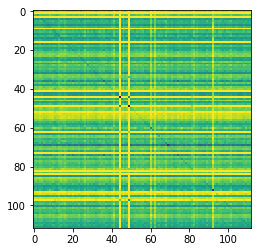

In [302]:
# tmp_df = pd.DataFrame.from_dict({'sim': sim_to_author, 'auth': author_list})
# tmp_df.sort_values(by='sim').head(10)
plt.imshow(deltas_authors_v_authors)
plt.clim(0,3)

In [12]:
# add some basic features for each article
mongo_id = []
n_words = []
n_sentences = []
n_wordspersentence = []
n_word_sent_var = []
author_list = []
author_id_n = []
n_nouns = []
n_adj = []
n_verb = []
n_adv =[]
# for sentiment analysis
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
# for more specific pos
# adj, comp adj, super adj, noun, proper sing n, proper pl n, 
# plural n, adv, comp adv, super avd
pos_test = ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNPS', 'NNS', 'RB', 'RBR', 'RBS']
extra_pos = {}
for curr_pos in pos_test:
    extra_pos[curr_pos] = []

# iterate over all writers
for curr_name in writer_df['website_name']:
    print(curr_name)
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        # mongo id number
        mongo_id.append(str(curr_art['_id']))
        # n words after cleaning and removing numbers and punctuation
        
        cleantext = clean_text(curr_art['article'])
        n_words.append(get_nwords(cleantext))
        # n sentences
        ns, nw_s, nw_s_var = get_nsentences(curr_art['article'])
        n_sentences.append(ns)
        n_wordspersentence.append(nw_s)
        n_word_sent_var.append(nw_s_var)
        # author list
        author_list.append(curr_name)
        # author id n
        author_id_n.append(curr_art['writer_id'])
        # remove stopwords from story
        nostopwords = remove_stopwords(word_tokenize(cleantext))
        typesofspeech = [get_pos(i) for i in nostopwords]
        n_nouns.append(typesofspeech.count('n'))
        n_adj.append(typesofspeech.count('a'))
        n_verb.append(typesofspeech.count('v'))
        n_adv.append(typesofspeech.count('r'))
        sentim_all = {}
        sentim_all['neg'] = []
        sentim_all['neu'] = []
        sentim_all['pos'] = []
        sentim_all['compound'] = []
        sentences = sent_tokenize(curr_art['article'])
        for i in sentences:
            vs = analyzer.polarity_scores(i)
            sentim_all['neg'].append(vs['neg'])
            sentim_all['neu'].append(vs['neu'])
            sentim_all['pos'].append(vs['pos'])
            sentim_all['compound'].append(vs['compound'])
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                         np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                         np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    elapsed = time.time() - t
    print(elapsed)
#         # for more specific pos
#         doc = nlp(curr_art['article'])
#         pos_vec = [token.tag_ for token in doc]        
#         for curr_pos in pos_test:
#             extra_pos[curr_pos].append(pos_vec.count(curr_pos))
          

zachlowe_nba
38.73399114608765
adrian-wojnarowski
8.622598886489868
lee-jenkins
28.317741870880127
howardbeck
10.94846487045288
marc-stein
6.440454006195068
ethan-sherwood-strauss
6.862703800201416
jason-concepcion
4.641931056976318
kevin-arnovitz
11.989131927490234
tom-haberstroh
12.1701500415802
nate-duncan


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.9044158458709717
zach-harper
2.1899027824401855
brian-windhorst
7.968173980712891
sam_amick
5.707959175109863
david-aldridge
17.333062171936035
ramona-shelburne
10.05358600616455
jpdabrams
11.040386199951172
kevin-pelton
11.32152795791626
marc-j-spears
12.16173005104065
matt-moore
11.606884002685547
shams-charania
5.440387010574341
kevin-p-oconnor
1.7267799377441406
chris-haynes
5.4901556968688965
dave-mcmenamin
7.003241777420044
shea-serrano
14.327958106994629
ian-begley
4.37597393989563
rachel-nichols
1.0117440223693848
ben-golliver
11.619072198867798
mike-prada
7.112704038619995
robmahoney
13.476242780685425
tim-macmahon
5.6943700313568115
chris-herring
6.495636224746704
billsimmons
5.670539855957031
jonathan-tjarks
12.951073169708252
amin-elhassen
0.0009350776672363281
bobby-marks
6.664451837539673
danny-leroux
5.884143114089966
chris-mannix
10.196951150894165
dan-devine
13.129455804824829
michael-pina
14.92750096321106
thompsonscribe
3.108916997909546
ben-golliver
11.34837388992

In [177]:
analyzer = SentimentIntensityAnalyzer()
avg_sentim = []
sentim_var = []
for curr_name in writer_df['website_name']:
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        sentim_all = {}
        sentim_all['neg'] = []
        sentim_all['neu'] = []
        sentim_all['pos'] = []
        sentim_all['compound'] = []
        sentences = sent_tokenize(curr_art['article'])
        for i in sentences:
        #             a = clean_text(i)
            vs = analyzer.polarity_scores(i)
            sentim_all['neg'].append(vs['neg'])
            sentim_all['neu'].append(vs['neu'])
            sentim_all['pos'].append(vs['pos'])
            sentim_all['compound'].append(vs['compound'])
        # take avg sentim for each story by averaging sentim for each sentence
        avg_sentim.append([np.mean(sentim_all['neg']), np.mean(sentim_all['neu']), 
                         np.mean(sentim_all['pos']), np.mean(sentim_all['compound'])])
        # take std of sentim for each story to measure sentiment variability
        sentim_var.append([np.std(sentim_all['neg']), np.std(sentim_all['neu']), 
                         np.std(sentim_all['pos']), np.std(sentim_all['compound'])])
    


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# build a pd of what we have so far
data = {'n_words': n_words, 'author_id_n': author_id_n, 'author_list': author_list, 'mongo_id': mongo_id,
        'n_nouns': n_nouns, 'n_adj': n_adj, 'n_verb': n_verb, 'n_adv': n_adv, 'n_sentences': n_sentences, 
        'n_wordspersentence': n_wordspersentence, 'n_wordspersent_variability': n_word_sent_var, 
        'neg_sent': [i[0] for i in avg_sentim], 'neu_sent': [i[1] for i in avg_sentim],
        'pos_sent': [i[2] for i in avg_sentim], 'neg_sent_var': [i[0] for i in sentim_var], 
       'neu_sent_var': [i[1] for i in sentim_var], 'pos_sent_var': [i[2] for i in sentim_var]}
writer_feature_df = pd.DataFrame.from_dict(data)
writer_feature_df.head()
# print(len(n_nouns))

In [233]:
# for word length, etc
wordlength = []
wordlength_var = []
wordlength_skew = []
for curr_name in writer_df['website_name']:
    # curr_name = 'zachlowe_nba'
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    for curr_art in y:
        # get word info
        curr_wordlength, curr_wordlength_var, curr_wordlength_skew = get_word_length(curr_art['article'])
        wordlength.append(curr_wordlength)
        wordlength_var.append(curr_wordlength_var)
        wordlength_skew.append(curr_wordlength_skew)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [308]:
# add these to df
writer_feature_df['wordlength'] = wordlength
writer_feature_df['wordlength_var'] = wordlength_var
writer_feature_df['wordlength_skew'] = wordlength_skew
writer_feature_df.head(25)

index  n_words  author_id_n   author_list                  mongo_id  \
0       0     2966       693716  zachlowe_nba  5b9c705c11919a2b1a15c30d   
1       1     2966       693716  zachlowe_nba  5b9c705d11919a2b1a15c30e   
2       2     2697       693716  zachlowe_nba  5b9c705f11919a2b1a15c30f   
3       3     2813       693716  zachlowe_nba  5b9c706011919a2b1a15c310   
4       4     2813       693716  zachlowe_nba  5b9c706111919a2b1a15c311   
5       5     2506       693716  zachlowe_nba  5b9c706311919a2b1a15c312   
6       6     2192       693716  zachlowe_nba  5b9c706411919a2b1a15c313   
7       7      205       693716  zachlowe_nba  5b9c706611919a2b1a15c314   
8       8     2163       693716  zachlowe_nba  5b9c706811919a2b1a15c315   
9       9     4442       693716  zachlowe_nba  5b9c706911919a2b1a15c316   
10     10     4442       693716  zachlowe_nba  5b9c706a11919a2b1a15c317   
11     11     2607       693716  zachlowe_nba  5b9c706c11919a2b1a15c318   
12     12     2607       693716  zachlowe_nba  5b9c706e11919a2b1a15c319   
13     13     2374       693716  zachlowe_nba  5b9c706f11919a2b1a15c31a   
14     14     2374       693716  zachlowe_nba  5b9c707111919a2b1a15c31b   
15     15     2224       693716  zachlowe_nba  5b9c707311919a2b1a15c31c   
16     16     3973       693716  zachlowe_nba  5b9c707411919a2b1a15c31d   
17     17     1623       693716  zachlowe_nba  5b9c707611919a2b1a15c31e   
18     18     2386       693716  zachlowe_nba  5b9c707811919a2b1a15c31f   
19     19     1714       693716  zachlowe_nba  5b9c707911919a2b1a15c320   
20     20     1714       693716  zachlowe_nba  5b9c707a11919a2b1a15c321   
21     21     1714       693716  zachlowe_nba  5b9c707c11919a2b1a15c322   
22     22      696       693716  zachlowe_nba  5b9c707d11919a2b1a15c323   
23     23     3115       693716  zachlowe_nba  5b9c707f11919a2b1a15c324   
24     24     1905       693716  zachlowe_nba  5b9c708111919a2b1a15c325   

    n_nouns  n_adj  n_verb  n_adv  n_sentences       ...         \
0      1245     67     413    102          185       ...          
1      1245     67     413    102          185       ...          
2      1000     60     363    112          151       ...          
3      1060     58     411     86          183       ...          
4      1060     58     411     86          183       ...          
5       803     68     393     63          203       ...          
6       849     44     311     76          132       ...          
7        87      2      36      1            8       ...          
8       836     44     306     75          129       ...          
9      1780    102     624    141          272       ...          
10     1780    102     624    141          272       ...          
11     1107     47     348    106          163       ...          
12     1107     47     348    106          163       ...          
13      854     50     338    115          124       ...          
14      854     50     338    115          124       ...          
15      776     49     313    113           89       ...          
16     1580     81     576    161          204       ...          
17      642     44     227     61           82       ...          
18      952     48     326    106          141       ...          
19      734     32     270     45           95       ...          
20      734     32     270     45           95       ...          
21      734     32     270     45           95       ...          
22      306     16      86     18           27       ...          
23     1144     45     522    141          211       ...          
24      703     37     260     83          121       ...          

    n_wordspersent_variability  neg_sent  neu_sent  pos_sent  neg_sent_var  \
0                    17.212670  0.078108  0.839638  0.082249      0.134054   
1                    17.212670  0.078108  0.839638  0.082249      0.134054   
2                    16.185666  0.037828  0.869960  0.092225      0.083719  

In [317]:
# write to postgresql database for later pulling
dbname = 'writer_feature_db'
username = 'rohanramesh' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
# writer_feature_df.to_sql('writer_feature', engine, if_exists='replace')

postgres://rohanramesh@localhost/writer_feature_db
True


In [8]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [318]:
# to add new columns to database- doesn't work?
writer_feature_df.to_sql('writer_feature', con=engine, if_exists='append')


In [321]:
# query to load entire db into pandas
sql_query = """
SELECT * FROM writer_feature;
"""
writer_feature_df = pd.read_sql_query(sql_query,con)

level_0  index  n_words  author_id_n   author_list  \
0        0      0     2966       693716  zachlowe_nba   
1        1      1     2966       693716  zachlowe_nba   
2        2      2     2697       693716  zachlowe_nba   
3        3      3     2813       693716  zachlowe_nba   
4        4      4     2813       693716  zachlowe_nba   

                   mongo_id  n_nouns  n_adj  n_verb  n_adv       ...         \
0  5b9c705c11919a2b1a15c30d     1245     67     413    102       ...          
1  5b9c705d11919a2b1a15c30e     1245     67     413    102       ...          
2  5b9c705f11919a2b1a15c30f     1000     60     363    112       ...          
3  5b9c706011919a2b1a15c310     1060     58     411     86       ...          
4  5b9c706111919a2b1a15c311     1060     58     411     86       ...          

   n_wordspersent_variability  neg_sent  neu_sent  pos_sent  neg_sent_var  \
0                   17.212670  0.078108  0.839638  0.082249      0.134054   
1                   17.212670  0.078108  0.839638  0.082249      0.134054   
2                   16.185666  0.037828  0.869960  0.092225      0.083719   
3                   11.751734  0.059246  0.854087  0.086639      0.106565   
4                   11.751734  0.059246  0.854087  0.086639      0.106565   

   neu_sent_var  pos_sent_var  wordlength  wordlength_var  wordlength_skew  
0      0.185814      0.143422    4.801696        2.667325         1.402407  
1      0.185814      0.143422    4.801696        2.667325         1.402407  
2      0.139230      0.123817    4.607130        2.427109         1.110728  
3      0.143424      0.122222    4.571527        2.405555         1.074744  
4      0.143424      0.122222    4.571527        2.405555         1.074744  

[5 rows x 22 columns]

In [304]:
#backup
writer_feature_df_backup = writer_feature_df

In [319]:

# query to test subsections
sql_query = """
SELECT * FROM writer_feature WHERE author_list ='timkawakami';
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)

level_0  index  n_words  author_id_n  author_list  \
0    10508  10504      331       693806  timkawakami   
1    10509  10505      159       693806  timkawakami   
2    10510  10506      154       693806  timkawakami   
3    10511  10507      156       693806  timkawakami   
4    10512  10508      154       693806  timkawakami   
5    10513  10509      147       693806  timkawakami   
6    10514  10510      150       693806  timkawakami   
7    10515  10511      799       693806  timkawakami   
8    10516  10512      157       693806  timkawakami   
9    10517  10513      156       693806  timkawakami   

                   mongo_id  n_nouns  n_adj  n_verb  n_adv       ...         \
0  5b9ccc3011919a2b1a15eb5b      112      4      50     14       ...          
1  5b9ccc3111919a2b1a15eb5c       51      3      21      6       ...          
2  5b9ccc3411919a2b1a15eb5d       53      3      24      6       ...          
3  5b9ccc3511919a2b1a15eb5e       62      0      18      6       ...          
4  5b9ccc3711919a2b1a15eb5f       53      2      18      7       ...          
5  5b9ccc3a11919a2b1a15eb60       59      4      17      6       ...          
6  5b9ccc3b11919a2b1a15eb61       59      5      16      4       ...          
7  5b9ccc3d11919a2b1a15eb62      289     24      96     35       ...          
8  5b9ccc3f11919a2b1a15eb63       59      6      24      5       ...          
9  5b9ccc4111919a2b1a15eb64       57      0      21      3       ...          

   n_wordspersent_variability  neg_sent  neu_sent  pos_sent  neg_sent_var  \
0                   12.642785  0.010533  0.939667  0.049800      0.039412   
1                   14.599171  0.017222  0.866222  0.116556      0.032365   
2                   16.675623  0.115667  0.844167  0.040167      0.241314   
3                   13.918850  0.049000  0.889250  0.061750      0.086324   
4                   15.217862  0.019833  0.892667  0.087500      0.044349   
5                   16.364671  0.015000  0.906556  0.078444      0.030529   
6                   20.241749  0.000000  0.945556  0.054444      0.000000   
7                   12.570795  0.072767  0.815558  0.111721      0.090451   
8                   12.398967  0.053625  0.914750  0.031625      0.099345   
9                   12.128937  0.023889  0.887111  0.089000      0.051317   

   neu_sent_var  pos_sent_var  wordlength  wordlength_var  wordlength_skew  
0      0.097387      0.079268    4.530864        2.706127         1.361324  
1      0.128622      0.123400    4.571429        2.307124         0.788946  
2      0.248116      0.110572    4.496855        2.497481         0.875794  
3      0.104215      0.089965    4.547591        2.467372         0.913818  
4      0.100472      0.107697    4.575000        2.354650         0.827905  
5      0.118191      0.097638    4.353659        2.466220         1.412358  
6      0.081021      0.081021    4.201117        2.172402         0.895213  
7      0.176715      0.145012    4.368098        2.267284         0.933033  
8      0.109978      0.042018    4.609756        2.473055         0.807092  
9      0.127154      0.129004    4.468000        2.534754         1.014436  

[10 rows x 22 columns]

In [320]:
# # save writer feature df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_4.pickle', 'wb') as handle:
    pickle.dump(writer_feature_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load
# with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_feature_df_2.pickle', 'rb') as handle:
#     writer_feature_df = pickle.load(handle)

In [11]:
# lets build features that will put in
# Features to include:
    # n_words
    # n_nouns/n_words
    # n_adj/n_words
    # n_verb/n_words
    # n_adv/n_words
    # n_sentences
    # n_wordspersentence
    # n_wordspersentence_variability
    # positive sentiment
    # neu sentiment
    # negative sentiment
    # positive sentiment variability
    # neu sentiment variability
    # negative sentiment variability

# do fractions
writer_feature_df['noun_fraction'] = writer_feature_df['n_nouns']/writer_feature_df['n_words']
writer_feature_df['adj_fraction'] = writer_feature_df['n_adj']/writer_feature_df['n_words']
writer_feature_df['adv_fraction'] = writer_feature_df['n_adv']/writer_feature_df['n_words']
writer_feature_df['verb_fraction'] = writer_feature_df['n_verb']/writer_feature_df['n_words']


In [12]:
features_use = ['n_words', 'noun_fraction', 'adj_fraction', 'adv_fraction', 'verb_fraction', 
               'neg_sent', 'pos_sent', 'neu_sent', 'neg_sent_var', 'neu_sent_var', 'pos_sent_var', 
               'n_sentences', 'n_wordspersentence', 'n_wordspersent_variability', 'author_list']
writer_feature_df_2 = writer_feature_df[features_use]
writer_feature_df_2.replace([np.inf, -np.inf], np.nan)
writer_feature_df_2 = writer_feature_df_2.dropna(axis=0, how='any')
# pd.isna(writer_feature_df_2)
print(np.shape(writer_feature_df_2))

(15964, 15)


In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
input_1 = pd.DataFrame.transpose(writer_feature_df_2)
pca.fit(input_1)
# a = writer_feature_df_2['n_wordspersentence']
# a.isnull().values.any()
a = pca.components_
print(np.shape(a))
plt.plot(a[0],a[1],'o')

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=1, perplexity=30, 
                  n_iter=1000).fit_transform(writer_feature_df_2.drop('author_list', axis=1))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15964 samples in 0.012s...
[t-SNE] Computed neighbors for 15964 samples in 0.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15964
[t-SNE] Computed conditional probabilities for sample 2000 / 15964
[t-SNE] Computed conditional probabilities for sample 3000 / 15964
[t-SNE] Computed conditional probabilities for sample 4000 / 15964
[t-SNE] Computed conditional probabilities for sample 5000 / 15964
[t-SNE] Computed conditional probabilities for sample 6000 / 15964
[t-SNE] Computed conditional probabilities for sample 7000 / 15964
[t-SNE] Computed conditional probabilities for sample 8000 / 15964
[t-SNE] Computed conditional probabilities for sample 9000 / 15964
[t-SNE] Computed conditional probabilities for sample 10000 / 15964
[t-SNE] Computed conditional probabilities for sample 11000 / 15964
[t-SNE] Computed conditional probabilities for sample 12000 / 15964
[t-SNE] Computed conditional probabilities for sam

(15964, 2)


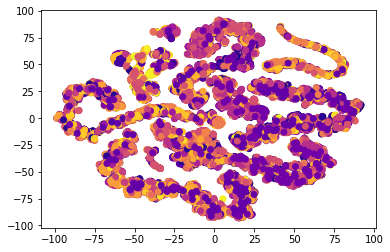

In [14]:
print(np.shape(X_embedded))
all_authors = writer_feature_df_2['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [509]:
# query
#         AVG("n_nouns"/"n_words") AS "noun_fraction",
#         AVG("n_adj"/"n_words") AS "adj_fraction",
#         AVG("n_adv"/"n_words") AS "adv_fraction",
#         AVG("n_verb"/"n_words") AS "verb_fraction",


sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent") AS "avg_neg_sent",
         AVG("neu_sent") AS "avg_neu_sent",
         AVG("pos_sent") AS "avg_pos_sent",
         AVG("neg_sent_var") AS "avg_neg_sent_var",
         AVG("neu_sent_var") AS "avg_neu_sent_var",
         AVG("pos_sent_var") AS "avg_pos_sent_var",
        AVG("n_sentences") AS "avg_n_sentences",
        AVG("n_wordspersentence") AS "avg_n_wordspersentence",
        AVG("n_wordspersent_variability") AS "avg_n_wordspersent_variability",
        AVG("wordlength") AS "avg_wordlength",
        AVG("wordlength_var") AS "avg_wordlength_var",
        AVG("wordlength_skew") AS "avg_wordlength_skew",
        "author_list"
FROM writer_feature
WHERE "n_words" > 100
GROUP BY "author_list"
HAVING COUNT(*) > 25 
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')

In [510]:
len(writer_feature_subsection)

90

In [512]:
# normalize new df
def normalize_df(df):
    result = df.copy()
    for feature_name in df.columns:
        if isinstance(df[feature_name][0], str):
            continue
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        result[feature_name] = (df[feature_name] - df[feature_name].mean()) / (df[feature_name].std())
#         result[feature_name] = (df[feature_name]) / norm(df[feature_name])
    return result

# same normalization but on vector
def normalize_vec(list1, means, var):
    output_vec = [(list1[i]-means[i])/var[i] for i in range(0,len(list1))]
    return output_vec
    

norm_writer_feature_subsection = normalize_df(writer_feature_subsection)

In [511]:
writer_feature_df.head()

index  n_words  author_id_n   author_list                  mongo_id  \
0      0     2966       693716  zachlowe_nba  5b9c705c11919a2b1a15c30d   
1      1     2966       693716  zachlowe_nba  5b9c705d11919a2b1a15c30e   
2      2     2697       693716  zachlowe_nba  5b9c705f11919a2b1a15c30f   
3      3     2813       693716  zachlowe_nba  5b9c706011919a2b1a15c310   
4      4     2813       693716  zachlowe_nba  5b9c706111919a2b1a15c311   

   n_nouns  n_adj  n_verb  n_adv  n_sentences       ...         \
0     1245     67     413    102          185       ...          
1     1245     67     413    102          185       ...          
2     1000     60     363    112          151       ...          
3     1060     58     411     86          183       ...          
4     1060     58     411     86          183       ...          

   n_wordspersent_variability  neg_sent  neu_sent  pos_sent  neg_sent_var  \
0                   17.212670  0.078108  0.839638  0.082249      0.134054   
1                   17.212670  0.078108  0.839638  0.082249      0.134054   
2                   16.185666  0.037828  0.869960  0.092225      0.083719   
3                   11.751734  0.059246  0.854087  0.086639      0.106565   
4                   11.751734  0.059246  0.854087  0.086639      0.106565   

   neu_sent_var  pos_sent_var  wordlength  wordlength_var  wordlength_skew  
0      0.185814      0.143422    4.801696        2.667325         1.402407  
1      0.185814      0.143422    4.801696        2.667325         1.402407  
2      0.139230      0.123817    4.607130        2.427109         1.110728  
3      0.143424      0.122222    4.571527        2.405555         1.074744  
4      0.143424      0.122222    4.571527        2.405555         1.074744  

[5 rows x 21 columns]

In [478]:
X_embedded = TSNE(n_components=2, 
                  verbose=1).fit_transform(norm_writer_feature_subsection.drop('author_list', axis=1))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 105 samples in 0.000s...
[t-SNE] Computed neighbors for 105 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 105 / 105
[t-SNE] Mean sigma: 1.712350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.947842
[t-SNE] Error after 1000 iterations: 0.329677


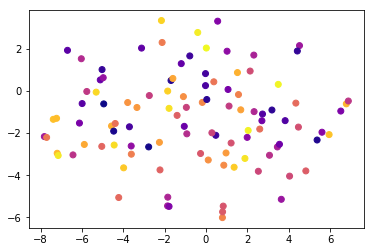

In [479]:
all_authors = writer_feature_subsection['author_list']
unique_authors = list(set(all_authors))
cm = plt.get_cmap('plasma_r',len(unique_authors))
cmap_colors = [cm.colors[unique_authors.index(i)] for i in all_authors]
np.shape(cm.colors)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cmap_colors[:])

In [513]:
# lets do all pairwise cosine similarities
nvals = np.shape(writer_feature_subsection)[0]
matsim_feat = np.ndarray(shape=(nvals,nvals))
for i in range(0,nvals):
    for j in range(0,nvals):
        vec1 = norm_writer_feature_subsection.iloc[i,:-1].values
        vec2 = norm_writer_feature_subsection.iloc[j,:-1].values
        result1 = cos_sim(vec1, vec2)
        matsim_feat[i, j] = result1

90
(90, 90)


Text(0,0.5,'Authors')

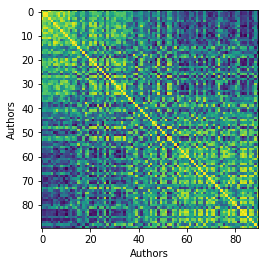

In [562]:
print(len(norm_writer_feature_subsection))
print(np.shape(matsim_feat))
plt.imshow(matsim_feat)
plt.xlabel('Authors')
plt.ylabel('Authors')

In [545]:
def give_suggestions_featurespace(matsim_feat, input_author, author_list):
    idx = author_list.index(input_author)
    tdf = pd.DataFrame.from_dict({'cos_sim': matsim_feat[idx,:], 'authors': author_list})
    a = tdf.sort_values(by='cos_sim', ascending=False)
    return a.iloc[0:5]

# go get the url
def grab_article(article_url):
    article = Article(article_url)
    article.download()
    article.parse()
    article.text
    return article

# def give_suggestion_featurespace_single_article(txtstr, means, stds, norm_feature_df):
def give_suggestion_featurespace_single_article(writer_feature_subsection, txtstr=None, url=None):
    if txtstr is not None:
        vec = build_feature_vector_for_article(txtstr)
    else:
        arti = grab_article(url)
        vec = build_feature_vector_for_article(arti.text)        
    norm_vec = normalize_vec(vec, writer_feature_subsection.mean().tolist(), 
                             writer_feature_subsection.std().tolist())
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list']
    # do similarity test
    similarity_vec = []
    for i in range(0,len(authors)):
        vec1 = norm_feature_df.iloc[i,:-1].values
        result1 = cos_sim(vec1, norm_vec)
        similarity_vec.append(result1)
    tdf = pd.DataFrame.from_dict({'cos_sim': similarity_vec, 'authors': authors})
    output_df = tdf.sort_values(by='cos_sim', ascending=False)
    return output_df.iloc[0:5]
        
def give_suggestions_deltaspace(deltas_authors_v_authors, input_author, author_list):
    idx = author_list.index(input_author)
    tdf = pd.DataFrame.from_dict({'delta_sim': deltas_authors_v_authors[idx,:], 'authors': author_list})
    a = tdf.sort_values(by='delta_sim', ascending=True)
#     a['authors'][0:10]
#     print(a.head(10))
    return a.iloc[0:10]

In [546]:
# b = (writer_feature_subsection.mean().tolist())
# a = (build_feature_vector_for_article(curr_art['article']))
# c = normalize_vec(a, writer_feature_subsection.mean().tolist(), writer_feature_subsection.std().tolist())
# print(c)
arti_url = 'http://www.espn.com/nba/story/_/id/24191536/zach-lowe-jimmy-butler-blake-griffin-nba-supermax'
# arti = grab_article(arti_url)
curr_name = 'zachlowe_nba'
currcol = mydb[curr_name]
y = currcol.find({"name": curr_name})
print(y.count())
a = give_suggestion_featurespace_single_article(writer_feature_subsection, url=arti_url)
print(a)

/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  # Remove the CWD from sys.path while we load stuff.


400
     cos_sim        authors
7   0.861038   zachlowe_nba
22  0.790760   ben-golliver
6   0.789322    billsimmons
1   0.788401  chris-ballard
10  0.784179   shea-serrano


In [384]:
tmp_auth_list = norm_writer_feature_subsection['author_list'].tolist()
give_suggestions_featurespace(matsim_feat, 'billsimmons', tmp_auth_list)

cos_sim           authors
75   1.000000       billsimmons
109  0.960355      chris-vernon
110  0.956097          bob-ryan
93   0.873145  jason-concepcion
65   0.789657          ben-falk

In [381]:
give_suggestions_deltaspace(deltas_authors_v_authors, 'lee-jenkins', author_list)

delta_sim                 authors
4     1.348194             lee-jenkins
17    1.374409           chris-ballard
1     1.447989     ian-oconnor-1027184
25    1.458531          michael-grange
7     1.480210            michael-pina
103   1.492037              adi-joseph
48    1.500533               jpdabrams
19    1.505536            ben-golliver
29    1.506141             zach-harper
23    1.512527  ethan-sherwood-strauss

In [558]:
def give_author_suggestion_from_author(writer_feature_subsection, author):
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list'].tolist()
    if author not in authors:
        return 'blah'
    else:
        idx = authors.index(author)
        norm_vec = norm_feature_df.iloc[idx][:-1]
        # do similarity test
        similarity_vec = []
        for i in range(0,len(authors)):
            vec1 = norm_feature_df.iloc[i,:-1].values
            result1 = cos_sim(vec1, norm_vec)
            similarity_vec.append(round(result1*10,2)) # multiply bu 10 to scale
        tdf = pd.DataFrame.from_dict({'similarity': similarity_vec, 'authors': authors})
        output_df = tdf.sort_values(by='similarity', ascending=False)
        return output_df.iloc[0:5]

In [547]:
writer_feature_subsection.to_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_features.pickle')

In [559]:
a = give_author_suggestion_from_author(writer_feature_subsection,'lee-jenkins')

['steve-kyler', 'chris-ballard', 'lee-jenkins', 'dennis-chambers', 'jared-zwerling', 'justin-willard', 'billsimmons', 'zachlowe_nba', 'alex-kennedy', 'david-aldridge', 'shea-serrano', 'jonathan-tjarks', 'james-holas', 'michael-pina', 'mika-honkasalo', 'britt-robson', 'mark-deeks', 'robmahoney', 'dan-devine', 'kevin-pelton', 'michael-lee', 'marc-j-spears', 'ben-golliver', 'tom-haberstroh', 'andrew-sharp', 'trevor-magnotti', 'kevin-arnovitz', 'matt-moore', 'jpdabrams', 'michael-grange', 'paul-flannery', 'seerat-sohi', 'howardbeck', 'showardcooper', 'chris-mannix', 'tim-bontemps', 'zach-harper', 'ramona-shelburne', 'ben-rohrbach', 'bobby-marks', 'paolo-uggetti', 'jason-concepcion', 'neil-paine', 'scott-rafferty', 'keith-smith', 'chris-herring', 'chris-sheridan', 'ken-berger', 'tom-ziller', 'rory-masterson', 'brian-windhorst', 'jeff-siegel', 'mike-prada', 'ethan-sherwood-strauss', 'sam-vecenie', 'david-thorpe', 'dave-mcmenamin', 'ben-falk', 'sam_amick', 'marc-stein', 'blake-murphy', 'tim-m

In [560]:
a

similarity          authors
2        10.00      lee-jenkins
1         9.70    chris-ballard
7         8.86     zachlowe_nba
9         7.85   david-aldridge
11        7.09  jonathan-tjarks